In [1]:
# those modules are almost always imported when working with model data
%matplotlib inline
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import xarray as xr # the major tool to work with NetCDF data!

import netCDF4
import os
from glob import glob
import numpy as np
import scipy.interpolate
import matplotlib.pyplot as plt
import pickle as pickle

## First load Gravity CSV for sampling

In [2]:
import pandas as pd
from glob import glob
def importOIBgrav(basedir, timedir):
    # datadir = 'IGGRV1B/temp'
    # infile = 'IGGRV1B_20091104_13100500_V016'
    # infile = 'IGGRV1B_20091031_11020500_V016'
    # infile = 'IGGRV1B_20091116_15124500_V016'
    suffix = '.txt'
    pattern = os.path.join(basedir, timedir, 'IGGRV1B_20161114_11243000_V017*' + suffix)
    infile = sorted(glob(pattern))  # , key=alphanum_key)

    ### Read ascii file as csv
    # metadata ends on line 69, column names on line 70
    headers = (
        'LAT', 'LONG', 'DATE', 'DOY', 'TIME', 'FLT', 'PSX', 'PSY', 'WGSHGT', 'FX', 'FY', 'FZ', 'EOTGRAV', 'FACOR',
        'INTCOR',
        'FAG070', 'FAG100', 'FAG140', 'FLTENVIRO')
    # print "Reading gravity file: %s" % infile[0] + suffix %TODO why did I think this would be a list?
    print("Reading gravity file: %s" % infile[0] + suffix)
    df = pd.read_csv(infile[0], delimiter=r"\s+", header=None, names=headers, skiprows=70)
    # headers = df.columns[1:df.shape[1]]
    # df.rename(columns=dict(zip(df.columns,headers)), inplace=True)
    # df.rename(columns={'LONG': 'LON'}, inplace=True)
    # df['ENVIRO'] = df.columns[[19]]
    # df.drop(df.columns['FLTENVIRO'],axis=1,inplace=True)

    ### do some DATETIME operations
    df['DATETIME'] = (df.DATE * 1e5) + df.TIME
    df['DATE'] = pd.to_datetime(df['DATE'], format='%Y%m%d')
    df['UNIX'] = df['DATE'].astype(np.int64) // 10 ** 9
    df['UNIX'] = df['UNIX'] + df['TIME']
    df['iunix'] = pd.to_datetime(df['UNIX'] * 10 ** 3, unit='ms')
    df.drop(['DATETIME'], axis=1, inplace=True)
    df = df.set_index('iunix')
    return df

basedir = '/Users/dporter/Documents/data_local/Antarctica/OIB/'
datadir = 'IGGRV1B'
timedir = 2016
grav = importOIBgrav(os.path.join(basedir, datadir), str(timedir))


Reading gravity file: /Users/dporter/Documents/data_local/Antarctica/OIB/IGGRV1B/2016/IGGRV1B_20161114_11243000_V017.txt.txt


In [3]:
grav.head()

,LAT,LONG,DATE,DOY,TIME,FLT,PSX,PSY,WGSHGT,FX,FY,FZ,EOTGRAV,FACOR,INTCOR,FAG070,FAG100,FAG140,FLTENVIRO,UNIX
iunix,,,,,,,,,,,,,,,,,,,,
2016-11-14 11:24:30.000,-53.004590,-70.845986,2016-11-14,319,41070.0,621,-3929452.26,1364844.81,50.57,5.01,-15.79,981296.93,NaN,NaN,NaN,NaN,NaN,NaN,-1,1.479123e+09
2016-11-14 11:24:30.500,-53.004590,-70.845986,2016-11-14,319,41070.5,621,-3929452.26,1364844.81,50.57,4.52,-15.33,981297.13,NaN,NaN,NaN,NaN,NaN,NaN,-1,1.479123e+09
2016-11-14 11:24:31.000,-53.004590,-70.845985,2016-11-14,319,41071.0,621,-3929452.27,1364844.82,50.56,3.46,-14.49,981297.14,NaN,NaN,NaN,NaN,NaN,NaN,-1,1.479123e+09
2016-11-14 11:24:31.500,-53.004590,-70.845985,2016-11-14,319,41071.5,621,-3929452.27,1364844.83,50.55,2.05,-13.60,981296.95,NaN,NaN,NaN,NaN,NaN,NaN,-1,1.479123e+09
2016-11-14 11:24:32.000,-53.004589,-70.845985,2016-11-14,319,41072.0,621,-3929452.28,1364844.85,50.54,0.73,-13.01,981296.61,NaN,NaN,NaN,NaN,NaN,NaN,-1,1.479123e+09


## ADMAP

In [98]:
basedir = '/Users/dporter/Documents/data_local/'
datadir = 'Antarctica/Geophysical/ADMAP/'

# suffix = '.dat'
# pattern = os.path.join(basedir, datadir, 'ant_new*' + suffix)

suffix = '.llz'
pattern = os.path.join(basedir, datadir, 'ADMAP_ORSTEDcombined' + suffix)

filenames = sorted(glob(pattern))  # , key=alphanum_key)
print(filenames)

admap = pd.read_csv(filenames[0], delimiter=r"\s+", names=('lat','lon','s'), header=None)
admap.head()

['/Users/dporter/Documents/data_local/Antarctica/Geophysical/ADMAP/ADMAP_ORSTEDcombined.llz']


,lat,lon,s
0,-61.01263,-90.00000,81.7168
1,-61.01673,-94.35863,96.8630
2,-61.02302,-94.18492,95.6766
3,-61.02905,-94.01113,94.6208
4,-61.03483,-93.83726,94.4395


In [99]:
def get_closest_ADMAP_cell(file_for_latlon, lat, lon):
    """
    SSIA
    :param file_for_latlon:
    :param lat:
    :param lon:
    :return:
    """
    LAT = file_for_latlon['lat'][:]
    LON = file_for_latlon['lon'][:]
#     print('lat,lon', lat,lon)
#     a = abs(LON - lon)
#     print(a.min())
#     print('Closest lat,lon', LAT[a.argmin()], LON[a.argmin()])
    
#     a = abs(LAT - lat)
#     print(a.min())
#     print('Closest lat,lon', LAT[a.argmin()], LON[a.argmin()])
    
#     a = abs(LON - lon) + abs(LAT - lat)
#     print(a.min())
#     print('Closest lat,lon', LAT[a.argmin()], LON[a.argmin()])
    return (abs(LON - lon) + abs(LAT - lat)).idxmin()


get_closest_ADMAP_cell(admap, grav['LAT'][0], grav['LONG'][0])

/Users/dporter/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:23: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.


2911

In [142]:
import time
start_sample = time.time()

grav['test2'] =  np.nan
# test2 = np.full([grav.shape[0], ], np.nan)
# lat_sample = np.full([grav.shape[0], ], np.nan)
# lon_sample = np.full([grav.shape[0], ], np.nan)
admap_sub = admap[grav['LONG'].max()+360 > admap['lon']+360][grav['LONG'].min()+360 < admap['lon']+360][grav['LAT'].max() > admap['lat']][grav['LAT'].min() < admap['lat']].describe()


for i in range(0, grav.shape[0], 140):
# for i in range(0, 30000, 50):
#     ii = get_closest_ADMAP_cell(admap, grav['LAT'][i], grav['LONG'][i])
    ii = (abs(admap_sub['lon'][:] - grav['LONG'][i]) + abs(admap_sub['lat'][:] - grav['LAT'][i])).idxmin()
#     print('ii: {}\njj: {}'.format(ii, jj))
#     lat_sample[i/50] = admap['lat'][ii]
#     lon_sample[i/50] = admap['lon'][ii]
#     print(lat_sample[i])
#     test[i] = ds['bouguer_anomaly'].isel(x=jj, y=ii).values
    grav['test2'].iloc[i] = admap_sub['s'][ii]
    
end_sample = time.time()
print(('Sampling took {} sec'.format(end_sample - start_sample)))


/Users/dporter/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Sampling took 333.6544909477234 sec


In [ ]:
start_sample = time.time()
def get_closest_cell(df_sample, lat, lon, latkey='lat', lonkey='lon'):
    print
    LAT = df_llz['lat'][:]
    LON = df_llz['lon'][:]
    a = abs(LON - lon) + abs(LAT - lat)

    return a.idxmin()

end_sample = time.time()
print(('Sampling took {} sec'.format(end_sample - start_sample)))

In [101]:
# grav['LAT']

u, indices = np.unique(grav['LAT'], return_index=True)
np.shape(grav['LAT'][indices])
# np.shape(grav['LAT'])

(79716,)

In [102]:
np.shape(admap['lon'])

(340037,)

In [103]:
print((np.shape(admap['lat'][grav['LAT'].max() > admap['lat']][grav['LAT'].min() < admap['lat']])))
lat_sub = admap['lat'][grav['LAT'].max() > admap['lat']][grav['LAT'].min() < admap['lat']]
lat_sub.describe()

(228112,)


count    228112.000000
mean        -66.480354
std           3.452837
min         -73.125270
25%         -69.344600
50%         -66.201175
75%         -63.462400
max         -61.012630
Name: lat, dtype: float64

In [104]:
grav['LONG'].describe()

count    91268.000000
mean       -67.800935
std          2.499773
min        -71.215982
25%        -70.406652
50%        -67.366447
75%        -65.719052
max        -61.829817
Name: LONG, dtype: float64

In [105]:
print((np.shape(admap['lon'][grav['LONG'].max() > admap['lon']][grav['LONG'].min() < admap['lon']])))
lon_sub = admap['lon'][grav['LONG'].max()+360 > admap['lon']+360][grav['LONG'].min()+360 < admap['lon']+360]
lon_sub.describe()

(8865,)


count    8865.000000
mean      -66.522049
std         2.709483
min       -71.214980
25%       -68.868330
50%       -66.522600
75%       -64.179010
max       -61.830100
Name: lon, dtype: float64

In [106]:
admap[grav['LONG'].max()+360 > admap['lon']+360][grav['LONG'].min()+360 < admap['lon']+360][grav['LAT'].max() > admap['lat']][grav['LAT'].min() < admap['lat']].describe()


/Users/dporter/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,lat,lon,s
count,5947.000000,5947.000000,5947.000000
mean,-66.479341,-66.523884,70.909998
std,3.453088,2.709919,113.311809
min,-73.125270,-71.214980,-386.646200
25%,-69.345405,-68.870290,10.391350
50%,-66.195070,-66.522600,63.571000
75%,-63.462045,-64.179010,125.009000
max,-61.014680,-61.830100,646.025900


#### Function
Sampling took 28.6072530746 sec (i/500)

Sampling took 67.8461468219 sec (i/140)

Sampling took 308.588253975 sec (i/50)

#### NO FUNCTION:
Sampling took 33.2082509995 sec (i/500)

Sampling took 264.135560036 sec (1/50)

### SUBSET ADMAP FIRST:
Sampling took 24 sec (i/500)

Sampling took 275.727045059 sec (1/50)

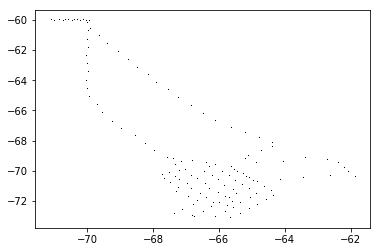

In [78]:
plt.plot(lon_sample, lat_sample, 'k,')

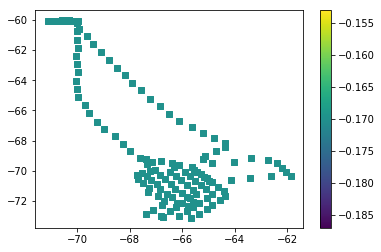

In [75]:
def fill_nan(a):
    from scipy import interpolate
    import numpy.ma as ma
    import numpy as np

    '''
    interpolate to fill nan values
    '''
    b = ma.filled(a, np.nan)
    inds = np.arange(b.shape[0])
    good = np.where(np.isfinite(b))
    f = interpolate.interp1d(inds[good], b[good], bounds_error=False)
    c = np.where(np.isfinite(b), b, f(inds))
    return c

# grav['test2'] = fill_nan(grav['test2'].values)
plt.scatter(lon_sample, lat_sample, c=fill_nan(grav['test2'].values), marker='s')
plt.colorbar()

count    183.000000
mean      40.552678
std       95.819424
min     -122.510000
25%       -1.700000
50%       12.420000
75%       69.520000
max      406.340000
Name: test2, dtype: float64


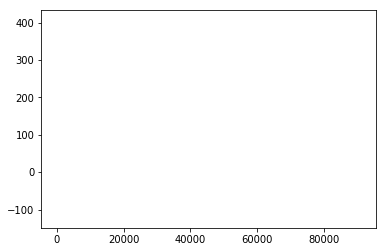

In [84]:
plt.plot(grav['test2'].values)
print((grav['test2'].describe()))